# Setup

In [171]:
import nltk
import time
import re
import numpy as np
import pandas as pd
import twint
import json
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools FOR TOPIC MODELING
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional  (I HAVEN'T USED THIS YET)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words -------------- ADD TO THESE AS WE SEE FIT
from nltk.corpus import stopwords

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# TWINT SCRAPING FROM TWITTER 

---

SEE https://github.com/twintproject/twint for options. The following cell returns a .csv file from all tweets containing 'Coronavirs' since the time specified by the [--since] option, in the [--lang] of english (en), and the csv file gets named after whatever iteration of scraping it is plus useful search parameters in the file name.


---

In [4]:
# THE TWINT COMMAND I USE IN TERMINAL TO SCRAPE

# twint -s Coronavirus --since "2020-03-24 20:00:00" --lang en -o just_cv_en_2 --csv

# Importing and Prepocessing 

---

**Open the corpus_pipeline to make changes, I'm sure there's lots of ways to clean tweets beyond simply regexing for emails and new line characters, probably way more preprocessing we can do, especially with .extending the stopwords.**

---

In [8]:
df3 = pd.read_csv('./just_cv/twint_3_en.csv')

In [9]:
df3.shape

(14400, 34)

In [10]:
df4 = pd.read_csv('./just_cv/twint_4_en.csv')

In [11]:
df4.shape

(14399, 34)

In [12]:
df5 = pd.read_csv('./just_cv/twint_5_en.csv')

In [13]:
df5.shape

(14399, 34)

In [14]:
df6 = pd.read_csv('./just_cv/twint_6_en.csv')

In [15]:
df6.shape

(14399, 34)

In [16]:
data3 = df3.tweet.values

In [17]:
data4 = df4.tweet.values

In [18]:
data5 = df5.tweet.values

In [19]:
data6 = df6.tweet.values

In [20]:
data = np.concatenate([data3, data4, data5, data6])

In [21]:
data.shape

(57597,)

In [22]:
data

array(['I said they are better than nothing, not that they are as good as the medical ones. There was no "bare face" group to fully show how effective the cloth masks are. The cloth masks are not meant to protect you from coronavirus, they are there to catch at least some of the 1/2',
       'Oops: CNN Forgot To Translate Its Latest Coronavirus Update From Mandarin |   https://babylonbee.com/news/cnn-embarassed-after-forgetting-to-translate-latest-coronavirus-update-from-mandarin-before-publishing\xa0…',
       'Speeding up https://twitter.com/ryanfiredragon/status/1242886374963007493\xa0…',
       ...,
       'Now that the Coronavirus Act is live, here are the links to the newly amended notices. In use from today  https://twitter.com/seccles74/status/1243161076394532865\xa0…',
       'Countries ranked for most cumulative cases of Coronavirus: \n\nChina 81,218\nItaly 74,386\nUSA 68,211\nSpain 49,515\nGermany 37,323\nIran 27,017\nFrance 25,233\nSwitzerland 10,897\nUK 9,529\nS. Korea 9,1

In [172]:
df_final = pd.DataFrame()

In [173]:
df_final['tweets'] = data

In [174]:
df_final

,tweets
0,"I said they are better than nothing, not that ..."
1,Oops: CNN Forgot To Translate Its Latest Coron...
2,Speeding up https://twitter.com/ryanfiredragon...
3,"Texas Gov. Greg Abbott, who routinely overrule..."
4,"Other than Satan, is there anyone more evil th..."
...,...
57591,Self employed no coronavirus bailout https://...
57592,"Paris St-Germain have made a 100,000 euro (£91..."
57593,"Now that the Coronavirus Act is live, here are..."
57594,Countries ranked for most cumulative cases of ...


**The following removes tweets with [n] words or less.**

In [175]:
types = []
for i in data:
    types.append(type(i))

In [176]:
index = 0
non_str = {}
fake = []
for i in data: 
    if type(i) != str:
        non_str[index] = type(i)
    index += 1

In [177]:
non_str

{}

In [178]:
for i in non_str:
    data = np.delete(data, i)

In [179]:
data[5665]

'Your president said that the coronavirus is a Chinese virus. Do you still want the Chinese people to like you in the United States?  Do you think anyone in the United States bullies?  Scolded us and smile at you Americans?  We are not China a century ago'

In [180]:
data.shape

(57596,)

In [29]:
# ndata = []
# for i in data:
#     if len(i.split(' ')) > 6:
#         ndata.append(i)

In [30]:
# len(data), len(ndata)

(57596, 56310)

In [181]:
more = ["news","case","make","would","death","spread","story","still","stop","kill","com", "twitter","pic","say","https"]
more2 = ["help","work","time","new","covid","get","test","day","http","country","good","world","may","government","pat"]
more3 = ["due","stay","be","report","worker","bill","back","first","people","corona"]
more4 = ["go","die","take","see","know","status","call",'Go','Say', 'www', 'many', 'see', 'make', 'want', 'be', 'could', "s", 'tell', 'today']
more5 = ['Let', 'Be', 'case', 'make', 'also', 'let', 'coronavirus', 'Coronavirus', 'Corona', 'must', 'much', 'thing', 'keep', 'even']


In [182]:
more.extend(more2)

In [183]:
more.extend(more3)

In [184]:
more.extend(more4)

In [185]:
more.extend(more5)

In [186]:
stop_words = stopwords.words('english')

In [187]:
len(more)

73

In [188]:
len(stop_words)

179

In [189]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [190]:
stop_words.extend(more)

In [191]:
len(stop_words)

257

**The following returns the [id2word] dictionary, [texts] which is the lemmatized data, and [corpus] which is the corpus.**

In [192]:
def corpus_pipeline(data):  
    # ********    THE FOLLOWING REGEXES SHOULD PROBABLY BE HEAVILY MODIFIED FOR CUSTOMIZING TWEETS CLEANING  *************
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # **********   ALSO PROBABLY REQUIRES EXTENSIVE ADDING OF TWEET-SPECIFIC STOPWORDS   ***********
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    
    data_words_trigrams = make_trigrams(data_words_bigrams)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, texts, corpus

# Pipeline for Dict, Texts, Corpus

In [193]:
id2word, texts, corpus = corpus_pipeline(data)

**The following makes many LDA (Latent Dirichlet Allocation models, from the gensim tutorial), but sometimes it randomly breaks and I don't know why, but the parameters take for more looking into to understand what's going on.**

In [40]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5): 
    """ Compute coherence values for various number of topics.
    Parameters:
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
        start : Int of lowest number of topics to model
        step : Int of increment to change number of topics to model
    Returns:
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        start=time.time()
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=1,
                                           per_word_topics=True)
                                            
        
        print(f'Topic modeling for {num_topics} topics took {time.time()-start} seconds.')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
# strt = 12
# lmt = 17
# stp = 1

In [ ]:
# ml, cov = compute_coherence_values(id2word, corpus, texts, lmt, strt, stp)

Topic modeling for 12 topics took 4.184603214263916 seconds.
Topic modeling for 13 topics took 4.124147891998291 seconds.


# Graphing and Visualizing the Modeled Topics (presumably, and ideally, distinct Twitter communites, such as those talking about government vs. domestic activity vs. memes vs. health advice

In [47]:
# def graph_coherence(coherence_values):
#     """ Graph a list of coherence values to determine the optimal number of topics to model. """
#     limit=lmt; start=strt; step=stp;
#     x = range(start, limit, step)
#     plt.plot(x, coherence_values)
#     plt.xlabel("Num Topics")
#     plt.ylabel("Coherence score")
#     plt.legend(("coherence_values"), loc='best')
#     plt.show()
    

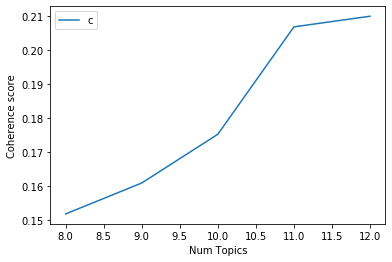

In [48]:
# graph_coherence(cov)

**In the following cells we can use the model with the highest coherence.**

In [ ]:
# ml[2] ## corresponds to the above model with 8 topics

In [ ]:
# ml[-1].

In [ ]:
# optimal_model = ml[-1]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

# LDA Model

In [194]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [195]:
lda_model.show_topics()

[(0,
  '0.033*"say" + 0.032*"pandemic" + 0.030*"outbreak" + 0.022*"business" + 0.019*"response" + 0.013*"way" + 0.013*"html" + 0.013*"late" + 0.012*"order" + 0.011*"emergency"'),
 (1,
  '0.051*"need" + 0.036*"crisis" + 0.024*"doctor" + 0.022*"event" + 0.018*"dlvr" + 0.014*"risk" + 0.013*"affect" + 0.012*"warn" + 0.011*"measure" + 0.011*"record"'),
 (2,
  '0.023*"home" + 0.019*"get" + 0.017*"go" + 0.017*"article" + 0.016*"health" + 0.015*"sign" + 0.014*"be" + 0.012*"tackle" + 0.012*"boris_johnson_demand" + 0.011*"support"'),
 (3,
  '0.020*"worker" + 0.020*"test" + 0.018*"economy" + 0.016*"show" + 0.014*"stimulus" + 0.014*"family" + 0.014*"money" + 0.013*"change" + 0.011*"mask" + 0.011*"well"'),
 (4,
  '0.056*"virus" + 0.019*"case" + 0.018*"fight" + 0.016*"lockdown" + 0.014*"hospital" + 0.013*"patient" + 0.013*"come" + 0.012*"death" + 0.012*"state" + 0.012*"update"'),
 (5,
  '0.043*"trump" + 0.018*"call" + 0.017*"thank" + 0.017*"right" + 0.016*"next" + 0.016*"job" + 0.014*"end" + 0.014*"

In [90]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.418413 -0.031753       1        1  16.626953
6      0.032261  0.414270       2        1  16.006191
3      0.094122 -0.112218       3        1  14.216688
5      0.072757 -0.075898       4        1  12.040063
7      0.055456 -0.026358       5        1  11.758904
0      0.047268 -0.058201       6        1  10.428045
4      0.054268 -0.060859       7        1   9.491005
2      0.062281 -0.048983       8        1   9.432158, topic_info=      Category         Freq                  Term        Total  loglift  \
75     Default  6710.000000                 virus  6710.000000  30.0000   
291    Default  2780.000000                  need  2780.000000  29.0000   
12     Default  2395.000000                   say  2395.000000  28.0000   
265    Default  2434.000000                 trump  2434.000000  27.0000   
178    Default  2170.000000              outbreak  2170.000000  26.0000   
...        ...          ...                   ...          ...      ...   
894     Topic8   341.959320              announce   342.846588   2.3585   
648     Topic8   327.669037                expert   328.555817   2.3583   
467     Topic8   314.298401                  kill   315.185425   2.3582   
1561    Topic8   300.483185                 allow   301.370819   2.3581   
23370   Topic8  1136.328491  boris_johnson_demand  1143.703491   2.3546   

       logprob  
75     30.0000  
291    29.0000  
12     28.0000  
265    27.0000  
178    26.0000  
...        ...  
894    -4.8515  
648    -4.8942  
467    -4.9358  
1561   -4.9808  
23370  -3.6506  

[271 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1123      7  0.997163     act
1869      7  0.996185      ad
761       8  0.998869  advice
491       5  0.998951  affect
49        1  0.999402     aid
...     ...       ...     ...
14        3  0.998912    well
664       2  0.998626    work
56        1  0.999242  worker
1019      4  0.999100   would
48        1  0.999047    year

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 6, 8, 1, 5, 3])

# Topic Assignment to Original Tweets

In [239]:
final_topics = []
for i in corpus:  
    topics = lda_model.get_document_topics(i)

    probs = {}
    for i in topics:
        probs[i[0]] = i[1]

    topic = max(probs, key=probs.get)
    final_topics.append(topic)

In [240]:
len(final_topics)

57596

In [198]:
df_final['topic'] = final_topics

In [202]:
topic_dict = {0: 'other',
              1: 'other',
              2: 'boris',
              3: 'economy',
              4: 'public_health',
              5: 'trump'}

In [204]:
df_final['topic_defined'] = df_final.topic.apply(lambda x: topic_dict[x])

In [212]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [213]:
analyser = SentimentIntensityAnalyzer()

df_final['sentiment'] = [analyser.polarity_scores(i) for i in df_final['tweets']]

In [236]:
df_final['compound_sentiment'] = [i['compound'] for i in df_final['sentiment']]
df_final['sentiment'] = df_final['compound_sentiment']
df_final.drop(columns=['compound_sentiment'], inplace=True)

In [241]:
df_final

,tweets,topic,topic_defined,sentiment
0,"I said they are better than nothing, not that ...",3,economy,0.6984
1,Oops: CNN Forgot To Translate Its Latest Coron...,0,other,0.0000
2,Speeding up https://twitter.com/ryanfiredragon...,4,public_health,0.0000
3,"Texas Gov. Greg Abbott, who routinely overrule...",4,public_health,0.6369
4,"Other than Satan, is there anyone more evil th...",4,public_health,-0.6901
...,...,...,...,...
57591,Self employed no coronavirus bailout https://...,4,public_health,-0.2273
57592,"Paris St-Germain have made a 100,000 euro (£91...",3,economy,0.3612
57593,"Now that the Coronavirus Act is live, here are...",4,public_health,0.0000
57594,Countries ranked for most cumulative cases of ...,4,public_health,0.0000


In [238]:
df_final.groupby('topic_defined')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
topic_defined,,,,,,,,
boris,16776.0,0.001269,0.505326,-0.9902,-0.4201,0.0,0.42150,0.9920
economy,1600.0,-0.030164,0.469112,-0.9788,-0.4013,0.0,0.34000,0.9664
other,4425.0,-0.035561,0.456815,-0.9589,-0.3954,0.0,0.31820,0.9890
public_health,33753.0,-0.018815,0.458946,-0.9935,-0.3818,0.0,0.34000,0.9928
trump,1042.0,-0.018735,0.489367,-0.9493,-0.4019,0.0,0.36585,0.9694


In [159]:
final_topics = []
for i in corpus:
    topics = []
    t = lda_model.get_document_topics(i)
    topics.append(t)
    
    probs = {}
    for i in topics:
        probs[i[0]] = i[1]

    max_topic = max(probs, key=probs.get)
    final_topics.append(max_topic)

In [91]:
# Save a dictionary into a pickle file.
import pickle

pickle.dump(vis, open("pyLDAvis_8_3456", "wb" ))

In [92]:
import pickle
vis = pickle.load( open( "pyLDAvis_8_3456", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d

# Visualizing and Findings

# Pickle

In [ ]:
# Save a dictionary into a pickle file.
import pickle

In [ ]:
pickle.dump(vis, open("pyLDAvis_8_3456", "wb" ))

In [ ]:
vis = pickle.load( open( "pyLDAvis_8_3456", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }d